In [2]:
BASEDIR = "."

import pandas
juju_data = pandas.read_csv(
    BASEDIR + '/juju/benchmark.csv',
    sep=";",
    comment="#"
)

juju_data.head()


,model_name,num_consumers,action,event,start,end,elapsed
0,k8s-test-5,5,deploy,pods,1.556271e+09,1.556271e+09,71.297592
1,k8s-test-5,5,deploy,juju,1.556271e+09,1.556271e+09,77.424011
2,k8s-test-5,5,change,pods,1.556271e+09,1.556271e+09,16.107294
3,k8s-test-5,5,change,juju,1.556271e+09,1.556271e+09,44.193782
4,k8s-test-5,5,change,pods,1.556271e+09,1.556271e+09,19.313293


In [20]:
BASEDIR = "."

import pandas
k8s_data = pandas.read_csv(
    BASEDIR + '/k8s/benchmark.csv',
    sep=";",
    comment="#"
)

k8s_data = k8s_data[k8s_data.num_consumers < 60]

k8s_data.head()


,namespace,num_consumers,action,event,start,end,elapsed
0,k8s-native-test,5,deploy,pods,1.556618e+09,1.556618e+09,2.694103
1,k8s-native-test,5,deploy,pods,1.556618e+09,1.556618e+09,2.934777
2,k8s-native-test,5,change,pods,1.556618e+09,1.556618e+09,2.918908
3,k8s-native-test,5,change,pods,1.556618e+09,1.556618e+09,4.032345
4,k8s-native-test,5,change,pods,1.556618e+09,1.556618e+09,3.907318


In [3]:
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt


def create_sane_figure():
    # You typically want your plot to be ~1.33x wider than tall.
    # Common sizes: (10, 7.5) and (12, 9)
    fig = plt.figure(figsize=(12, 6))  # a new figure window
    ax = fig.add_subplot(1, 1, 1)      # specify (nrows, ncols, axnum)

    # Put the axis behind the datapoints
    ax.set_axisbelow(True)
    # Grey ticks, labels, and axis'
    for spine in ax.spines.values():
        spine.set_color('black')
    for line in ax.get_xticklines() + ax.get_yticklines():
        line.set_color('black')
    ax.set_xlabel(None, fontsize=16, color='black')
    ax.set_ylabel(None, fontsize=16, color='black')
    # Don't show a grid
    ax.grid(False)
    # remove top and right border of graph
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(
        axis='both', which='both',
        labelsize=14, labelcolor='black',
        color='black')
    # Make the title big enough so it spans the entire plot, but don't make it
    # so big that it requires two lines to show.
    ax.set_title(None, fontsize=22, color='black')
    return (fig, ax)

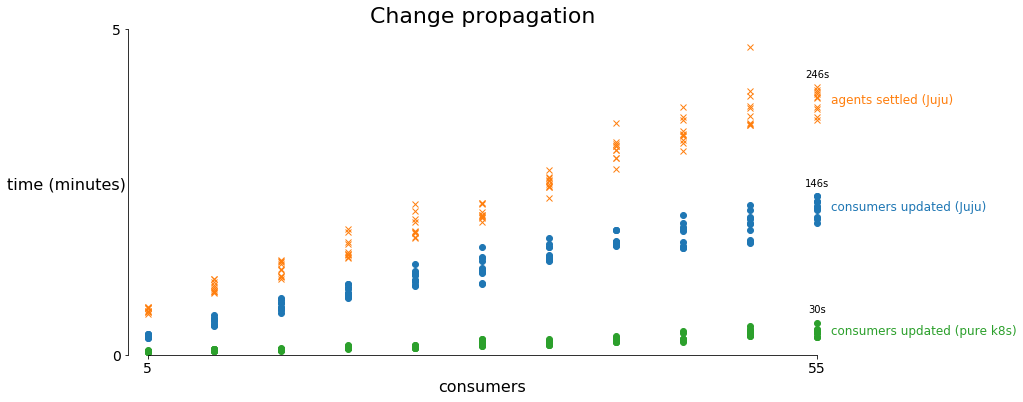

In [64]:
%matplotlib inline

changedatap_juju = juju_data[(juju_data["action"]=="change") & (juju_data['event'] == "pods")]
changedataj_juju = juju_data[(juju_data["action"]=="change") & (juju_data['event'] == "juju")]
deploydatap_juju = juju_data[(juju_data["action"]=="deploy") & (juju_data['event'] == "pods")]
deploydataj_juju = juju_data[(juju_data["action"]=="deploy") & (juju_data['event'] == "juju")]
changedata_k8s = k8s_data[(k8s_data["action"]=="change") & (k8s_data['event'] == "pods")]

def create_multiple_soy_clusters():
    (fig, ax) = create_sane_figure()

    ax.set_title("Change propagation", fontsize=22)
    ax.set_xlabel("consumers")
    ax.set_yticks([0,5])
    ax.set_ylabel("time (minutes)", rotation='horizontal', labelpad=45)
#     ax.set_ylabel('abc', rotation=0, fontsize=20, labelpad=20)
#     plt.margins(4)
#     ax.set_yticklabels(["0 minutes", "5 minutes"])

    pods_juju_plot = ax.plot(
        changedatap_juju['num_consumers'], changedatap_juju['elapsed']/60,'o',
        clip_on=False,
    )
    agents_plot = ax.plot(
        changedataj_juju['num_consumers'], changedataj_juju['elapsed']/60,'x',
        clip_on=False,
    )
    pods_k8s_plot = ax.plot(
        changedata_k8s['num_consumers'], changedata_k8s['elapsed']/60,'o',
        clip_on=False,
    )
    
    xs = []
    [xs.extend(l.get_xdata()) for l in ax.lines]
    xmax = max(xs)
    xmin = min(xs)
    
    import statistics
    
    plt.text(xmax+1, statistics.mean(changedatap_juju[changedatap_juju['num_consumers'] == xmax]['elapsed'])/60-0.03, 'consumers updated (Juju)', fontsize=12, color=pods_juju_plot[0].get_color())
    plt.text(xmax+1, statistics.mean(changedataj_juju[changedataj_juju['num_consumers'] == xmax]['elapsed'])/60-0.03, 'agents settled (Juju)', fontsize=12, color=agents_plot[0].get_color())
    plt.text(xmax+1, statistics.mean(changedata_k8s[changedata_k8s['num_consumers'] == xmax]['elapsed'])/60-0.03, 'consumers updated (pure k8s)', fontsize=12, color=pods_k8s_plot[0].get_color())
    
    
    ax.annotate(
        '{}s'.format(round(max(changedatap_juju[changedatap_juju['num_consumers'] == xmax]['elapsed']))),
        (xmax, 0.15 + max(changedatap_juju[changedatap_juju['num_consumers'] == xmax]['elapsed'])/60),
        ha='center')
    ax.annotate(
        '{}s'.format(round(max(changedataj_juju[changedataj_juju['num_consumers'] == xmax]['elapsed']))),
        (xmax, 0.15 + max(changedataj_juju[changedataj_juju['num_consumers'] == xmax]['elapsed'])/60),
        ha='center')
    ax.annotate(
        '{}s'.format(round(max(changedata_k8s[changedata_k8s['num_consumers'] == xmax]['elapsed']))),
        (xmax, 0.15 + max(changedata_k8s[changedata_k8s['num_consumers'] == xmax]['elapsed'])/60),
        ha='center')
    
#     ax.annotate('{} minutes'.format(round(max(changedatap_juju[changedatap_juju['num_consumers'] == xmax]['elapsed'])/60)),
#                 xy=(xmax, max(changedatap_juju[changedatap_juju['num_consumers'] == xmax]['elapsed'])/60),
#                 xycoords='data',
#                 xytext=(-40, 30), textcoords='offset points',
#                 arrowprops=dict(arrowstyle="->"))
    
    
    
    ax.set_xticks([xmin, xmax])

    
    ax.set_xlim(left=xmin, right=xmax)
    ax.set_ylim(bottom=0, top=5)
    ax.spines['left'].set_position(('outward', 20))

    # Save the plot to a file
    fig.savefig("base_url_propagation.png", bbox_inches="tight")
    fig.savefig("base_url_propagation.tiff", bbox_inches="tight", dpi=300)
    fig.show()
create_multiple_soy_clusters()